# Linear diffusion - time evolution / benchmarking

Now we assume that for any of the three models, we integrate through time to determine how the localization pattern progresses.

In [2]:
from quagmire import SurfaceProcessMesh, FlatMesh
from quagmire import tools as meshtools
from quagmire import function as fn
from quagmire import mesh as qmesh
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
minX, maxX = 0.0, 1.0
minY, maxY = 0.0, 1.0,
dx, dy = 0.02, 0.02

x1, y1, simplices = meshtools.square_mesh(minX, maxX, minY, maxY, dx, dy, random_scale=0.0)
DM = meshtools.create_DMPlex(x1, y1, simplices, boundary_vertices=None)
mesh = FlatMesh(DM, verbose=False, tree=True)

# boundary_mask_fn = fn.misc.levelset(mesh.mask, 0.5)

In [4]:
from scipy.special import erf, erfc

def halfspace_cooling(kappa, y, t):
    
    T = 1.0-erfc(0.5 * y / np.sqrt(kappa * t))
    return T

# Avoid the singular value in T(y,t) when t=0.0

time0 = 0.0001

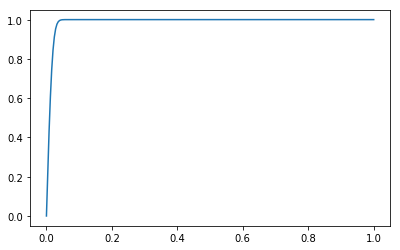

In [5]:
import matplotlib.pyplot as plt

Zs = np.linspace(0.0,1.0,250)
Ts = halfspace_cooling(1.0, Zs, time0)

figure = plt.figure(figsize=(5,3))
ax1 = figure.add_axes((0.0, 0.0, 1.0, 1.0))

ax1.plot(Zs, Ts)

In [6]:
cold_boundary_mask_fn = fn.misc.levelset( fn.misc.coord(dirn=1),  0.99)
hot_boundary_mask_fn  = fn.misc.levelset( fn.misc.coord(dirn=1),  0.01, invert=True)
non_boundary_mask     = (fn.parameter(1.0) - cold_boundary_mask_fn - hot_boundary_mask_fn)

dirichlet_mask = cold_boundary_mask_fn + hot_boundary_mask_fn
neumann_x_mask = fn.misc.levelset( fn.misc.coord(dirn=0),  0.01, invert=True) + fn.misc.levelset( fn.misc.coord(dirn=0),  0.99, invert=False)
neumann_y_mask = fn.parameter(0.0)

kappa = fn.parameter(1.0)

## Diffusion solver

In [7]:
time = time0
experiment_name = "TemperatureDiffusion_K=1"

In [8]:
import quagmire.equation_systems as systems

diffusion_solver = systems.DiffusionEquation(mesh=mesh)

# What the diffusion solver needs to run 

diffusion_solver.neumann_x_mask = neumann_x_mask
diffusion_solver.neumann_y_mask = neumann_y_mask
diffusion_solver.dirichlet_mask = dirichlet_mask
diffusion_solver.diffusivity = kappa

diffusion_solver.verify() # Does nothing but is supposed to check we have everything necessary

temperature = diffusion_solver.phi
temperature.data = halfspace_cooling(1.0, 1.0-mesh.tri.y, time0)
temp0 = temperature.copy()

## Diffusion time limit

In [9]:
diff_timestep = diffusion_solver.diffusion_timestep()
print("Diffusion timestep limit = {}".format(diff_timestep))

Diffusion timestep limit = 6.666666666666667e-05


## Diffusion solver / time integration

In [10]:
## Solve this and keep some intermediate results

print("Integrate t -> t + 0.01")
diffusion_solver.time_integration(diff_timestep, Delta_t=0.01)
temp001 = temperature.copy()

print("Integrate t -> t + 0.04")
diffusion_solver.time_integration(diff_timestep, Delta_t=0.04)
temp005 = temperature.copy()

print("Integrate t -> t + 0.05")
diffusion_solver.time_integration(diff_timestep, Delta_t=0.05)
temp01 = temperature.copy()

print("Integration ... complete")


Integrate t -> t + 0.01
Integrate t -> t + 0.04
Integrate t -> t + 0.05
Integration ... complete


## Compare to analytic solutions

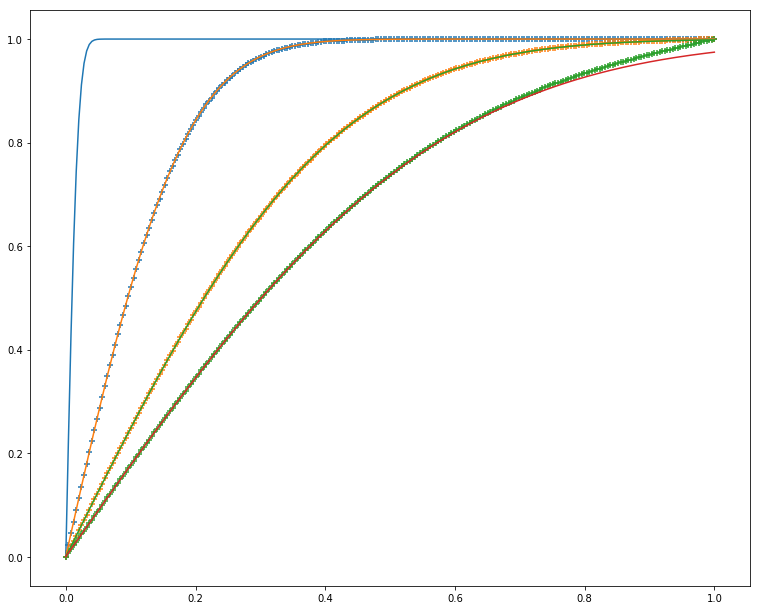

In [11]:
## Obtain horizontal profiles

Zs = np.linspace(0.0,1.0,250)
Ts0001 = halfspace_cooling(1.0, Zs, time0)
Ts001 = halfspace_cooling(1.0, Zs, 0.01)
Ts005 = halfspace_cooling(1.0, Zs, 0.05)
Ts01  = halfspace_cooling(1.0, Zs, 0.1)


TsN001 = temp001.evaluate(0.0*Zs, 1.0-Zs)
TsN005 = temp005.evaluate(0.0*Zs, 1.0-Zs)
TsN01  = temp01.evaluate(0.0*Zs, 1.0-Zs)

figure = plt.figure(figsize=(10,8))
ax1 = figure.add_axes((0.0, 0.0, 1.0, 1.0))

ax1.plot(Zs, Ts0001)
ax1.plot(Zs, Ts001)
ax1.plot(Zs, Ts005)
ax1.plot(Zs, Ts01)

ax1.scatter(Zs, TsN001, marker="+")
ax1.scatter(Zs, TsN005, marker="+")
ax1.scatter(Zs, TsN01,  marker="+")

pass

## Browse 


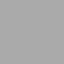

In [21]:
import lavavu

points = np.column_stack([mesh.tri.points, np.zeros(mesh.npoints)])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values( temp0.evaluate(mesh) , "T0001")
tri1.values( temp001.evaluate(mesh) ,  "T001")
tri1.values( temp005.evaluate(mesh) ,  "T005")
tri1.values( temp01.evaluate(mesh) ,  "T01")


tri1.colourmap("coolwarm")
tri1.colourbar(visible=True)

lv.control.Window()
tri1.control.List(options=
                  ["T0001","T001", "T005", "T01"], 
                   property="colourby", value="T0001", command="redraw")
lv.control.show()




# Spatially variable diffusivity (circular "inclusion")

Re-define the diffusivity and load into the equation solver. This is obviously not the optimal way to solve this problem - explicit timestepping is slow with the jump in diffusivity - but it is illustrative.

It would also be straightforward to add points close to the boundary to improve the resolution at the interface. Stripy does not offer contrained triangulations at this stage so we are not able to mesh the boundary itself.


In [13]:
kappa1 = fn.parameter(1.0) + fn. parameter(99.0) * fn.misc.levelset(
                                 (fn.misc.coord(0) - fn.parameter(0.5))**2 + 
                                 (fn.misc.coord(1) - fn.parameter(0.5))**2, 0.04)

diffusion_solver.diffusivity = kappa1
diff_timestep = diffusion_solver.diffusion_timestep()

time0 = 0.0
print("Diffusive timestep = {}".format(diff_timestep))

Diffusive timestep = 6.666666666666667e-07


Also reset the initial temperature - let's start from kappa=1.0 steady state case 
(i.e. a linear temperature gradient)

In [14]:
temperature.data = (fn.parameter(1.0) - fn.misc.coord(1)).evaluate(mesh)
temp0 = temperature.copy()

In [15]:
## Solve this and keep some intermediate results

print("Integrate t -> t + 0.001")
steps, dt = diffusion_solver.time_integration(diff_timestep, Delta_t=0.001, feedback=500)
temp001 = temperature.copy()

print("Integrate t -> t + 0.004")
steps, dt = diffusion_solver.time_integration(diff_timestep, Delta_t=0.004, feedback=500)
temp005 = temperature.copy()

print("Integrate t -> t + 0.005")
steps, dt = diffusion_solver.time_integration(diff_timestep, Delta_t=0.005, feedback=500)
temp01 = temperature.copy()


Integrate t -> t + 0.001
00000 - t = 6.67e-07
00500 - t = 0.000334
01000 - t = 0.000668
Integrate t -> t + 0.004
00000 - t = 6.67e-07
00500 - t = 0.000334
01000 - t = 0.000667
01500 - t = 0.001
02000 - t = 0.00133
02500 - t = 0.00167
03000 - t = 0.002
03500 - t = 0.00233
04000 - t = 0.00267
04500 - t = 0.003
05000 - t = 0.00333
05500 - t = 0.00367
Integrate t -> t + 0.005
00000 - t = 6.67e-07
00500 - t = 0.000334
01000 - t = 0.000667
01500 - t = 0.001
02000 - t = 0.00133
02500 - t = 0.00167
03000 - t = 0.002
03500 - t = 0.00233
04000 - t = 0.00267
04500 - t = 0.003
05000 - t = 0.00333
05500 - t = 0.00367
06000 - t = 0.004
06500 - t = 0.00433
07000 - t = 0.00467


In [16]:
dTdx_fn = temperature.fn_gradient(0) * (fn.parameter(1.0)-neumann_x_mask)
dTdy_fn = temperature.fn_gradient(1) * (fn.parameter(1.0)-neumann_y_mask)

flux = np.zeros((mesh.npoints, 3))
flux[:,0] = dTdx_fn.evaluate(mesh)
flux[:,1] = dTdy_fn.evaluate(mesh)


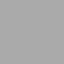

In [22]:
import lavavu

points = np.column_stack([mesh.tri.points, np.zeros(mesh.npoints)])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

vec1 = lv.vectors("flux_arrows", visible=True, colour="Blue" )
vec1.vertices(points)
vec1.vectors(flux)
vec1.colourmap("coolwarm")

tri0 = lv.triangles("Mesh", wireframe=True, colour="Grey")
tri0.vertices(points)
tri0.indices(mesh.tri.simplices)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values( kappa1.evaluate(mesh) , "kappa")
tri1.values( temperature.evaluate(mesh) , "T")
tri1.values( (temp01-temp0).evaluate(mesh) , "dT01")
tri1.values( (temp001-temp0).evaluate(mesh) , "dT001")


tri1.colourmap("coolwarm")
tri1.colourbar(visible=True)

lv.control.Panel()
vec1.control.Checkbox(property="visible", command="redraw", label="Flux")
tri0.control.Checkbox(property="visible", command="redraw", label="Mesh")
tri1.control.Checkbox(property="visible", command="redraw", label="T")
tri1.control.List(options=
                 ["kappa","T", "dT01", "dT001"], 
                  property="colourby", value="kappa", command="redraw")
lv.control.show()



In [18]:
## Mesh refinement
##
## Add a bunch of mesh points at the (known) interface location




In [23]:
temperature.data = (fn.parameter(1.0) - fn.misc.coord(1)).evaluate(mesh)

print("Integrate t -> t + 0.01")
steps, dt = diffusion_solver.time_integration(2.0*diff_timestep, Delta_t=0.01, feedback=500)
temp015 = temperature.copy()


Integrate t -> t + 0.01
00000 - t = 1.33e-06
00500 - t = 0.000668
01000 - t = 0.00133
01500 - t = 0.002
02000 - t = 0.00267
02500 - t = 0.00334
03000 - t = 0.004
03500 - t = 0.00467
04000 - t = 0.00534
04500 - t = 0.006
05000 - t = 0.00667
05500 - t = 0.00734
06000 - t = 0.008
06500 - t = 0.00867
07000 - t = 0.00934



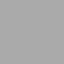

In [26]:
import lavavu

points = np.column_stack([mesh.tri.points, np.zeros(mesh.npoints)])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

vec1 = lv.vectors("flux_arrows", visible=True, colour="Blue" )
vec1.vertices(points)
vec1.vectors(flux)
vec1.colourmap("coolwarm")

tri0 = lv.triangles("Mesh", wireframe=True, colour="Grey")
tri0.vertices(points)
tri0.indices(mesh.tri.simplices)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values( kappa1.evaluate(mesh) , "kappa")
tri1.values( temperature.evaluate(mesh) , "T")
tri1.values( (temp015-temp0).evaluate(mesh) , "dT015")
tri1.values( (temp01-temp0).evaluate(mesh) , "dT01")


tri1.colourmap("coolwarm")
tri1.colourbar(visible=True)

lv.control.Panel()
vec1.control.Checkbox(property="visible", command="redraw", label="Flux")
tri0.control.Checkbox(property="visible", command="redraw", label="Mesh")
tri1.control.Checkbox(property="visible", command="redraw", label="T")
tri1.control.List(options=
                 ["kappa","T", "dT015", "dT01"], 
                  property="colourby", value="kappa", command="redraw")
lv.control.show()

